In [1]:
from __future__ import print_function,division
import numpy as np
import traveltimes
import pyfits
import read_params
import os
import matplotlib
from matplotlib import pyplot as plt,ticker,patches
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline

nx = read_params.get_nx()
Lx = read_params.get_xlength()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False)
k = 2*np.pi*np.fft.fftfreq(nx,x[1]-x[0])
dx = x[1]-x[0]
dt = read_params.get_dt()
Rsun= 6.95989467700E2
z=np.loadtxt(read_params.get_solarmodel(),usecols=[0])
z=(z-1)*Rsun
datadir = read_params.get_directory()

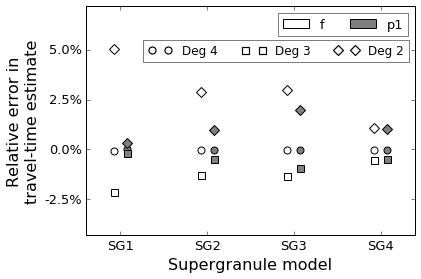

In [23]:
def time_shift(arr,delta_t):
    return np.fft.ifft(np.fft.fft(arr)*np.exp(-1j*w*delta_t)).real

def window(arr,x,modespeed,halftime):
    t_pix = int(abs(x-srcloc)/modespeed/(dt/60))
    loc=arr[t_pix:t_pix + 40].argmax()+t_pix
    return int(max(1,loc-halftime)),int(min(nt,loc+2*halftime))


src=5
srcloc = np.loadtxt(os.path.join(datadir,"master.pixels"))[src-1]

datadir_list = [os.path.join(os.path.dirname(read_params.get_directory()),
        "spline_SG{:d}".format(SGno)) for SGno in xrange(1,5)]

modes_list={0:'fmode'}
for i in xrange(1,4): 
    modes_list[i]='p{:d}mode'.format(i)
    
colors = {0:{"mfc":"orange","mec":"darkred"},
          1:{"mfc":"royalblue","mec":"royalblue"},
          2:{"mfc":"mediumseagreen","mec":"darkslategrey"},
          3:{"mfc":"hotpink","mec":"indigo"}}

colors = {0:{"mfc":"white","mec":"0"},
          1:{"mfc":"0.5","mec":"0"}}



handles=[]

for SGno,datadir in enumerate(datadir_list):
    
    for modeno,mode in enumerate([modes_list[0],modes_list[1]]):
        halftime=np.loadtxt(os.path.join(datadir,'params.{:d}'.format(modeno)))[2]       
    
        data = np.squeeze(pyfits.getdata(os.path.join(datadir,'data','{:02d}.fits'.format(src))))

        mode_filter = np.squeeze(pyfits.getdata('{}_filter.fits'.format(mode)))
        data_filtered = np.fft.ifft2(np.fft.fft2(data)*mode_filter).real

        nt=data.shape[0]
        w = np.fft.fftfreq(nt,dt)*2*np.pi

        with open("wavespeeds") as f:
            mode_speed=float(f.readlines()[modeno].strip().split()[0].replace("D","E"))

        rcv_pix,rcv_tt = np.loadtxt(
            os.path.join(datadir,"tt","iter00","ttdiff_src{:02d}.{}.0".format(src,mode)),
                              usecols=[0,1],unpack=True)

        max_tt = abs(rcv_tt).max()
        max_tt_pix = int(rcv_pix[abs(rcv_tt).argmax()])
        max_tt_pix_xcoord = x[max_tt_pix]

        data_rcv = data_filtered[:,max_tt_pix]
        data_rcv_shifted = time_shift(data_rcv,max_tt)
        win_low,win_high = window(data_rcv,max_tt_pix_xcoord,mode_speed,halftime)
        tt3=traveltimes.compute_tt_gizonbirch3(data_rcv,data_rcv_shifted,dt,win_low,win_high)
        tt2=traveltimes.compute_tt_gizonbirch2(data_rcv,data_rcv_shifted,dt,win_low,win_high)
        tt1=traveltimes.compute_tt_gizonbirch1(data_rcv,data_rcv_shifted,dt,win_low,win_high)    

        shift = 0.15
        deg3,=plt.plot([SGno+shift*modeno],(tt3-max_tt)/max_tt,marker='o',
                       mfc=colors[modeno]["mfc"],mec=colors[modeno]["mec"],
                         label="{}".format(mode.replace("mode","")),
                           ls="None",ms=7,mew=1);
        deg2,=plt.plot([SGno+shift*modeno],(tt2-max_tt)/max_tt,marker='s',
                       mfc=colors[modeno]["mfc"],mec=colors[modeno]["mec"],
                         label="{}".format(mode.replace("mode","")),
                           ls="None",ms=7,mew=1);
        deg1,=plt.plot([SGno+shift*modeno],(tt1-max_tt)/max_tt,marker='D',
                       mfc=colors[modeno]["mfc"],mec=colors[modeno]["mec"],
                         label="{}".format(mode.replace("mode","")),
                            ls="None",ms=7,mew=1);
        
        if SGno==0:
            handles.extend([deg3,deg2,deg1])
    
        
plt.xticks(np.arange(len(datadir_list))+shift*(len(handles)//3-1)/2,
           ['SG'+str(i) for i in xrange(1,len(datadir_list)+1)])

# plt.legend(handles=handles,
#            loc="best",fontsize=13,ncol=2,bbox_to_anchor=(1.02,1));

handles_modes=[]
for modeno,mode in enumerate([modes_list[0],modes_list[1]]):
    handles_modes.append(matplotlib.patches.FancyBboxPatch((0,0),1,1,
                boxstyle="sawtooth,pad=0.3,tooth_size=0.5",
                color=colors[modeno]["mfc"],
                ec=colors[modeno]["mec"],
                label=mode.replace("mode","")))

legend1=plt.legend(handles=handles_modes,
           loc="upper right",fontsize=13,ncol=4,bbox_to_anchor=(1,1));
legend1.get_frame().set_linewidth(0.5)

plt.gca().add_artist(legend1)


handles_deg =[]
for deg in xrange(3):
    handles_deg.append(matplotlib.lines.Line2D([],[],marker=handles[deg].get_marker(),
                    mfc="white",mec="black",ms=handles[deg].get_markersize(),ls="None",
                    label="Deg {:d}".format(4-deg),mew=1.2))

legend2=plt.legend(handles=handles_deg,loc="upper right",ncol=3,bbox_to_anchor=(1,0.88))
legend2.get_frame().set_linewidth(0.5)

plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(6))

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'
    
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(to_percent))
plt.ylabel("Relative error in\ntravel-time estimate",fontsize=16);
plt.xlabel("Supergranule model",fontsize=16);
plt.tick_params(axis="both",labelsize=13);
plt.margins(y=0.3,x=0.1)

plt.gcf().set_size_inches(6,4)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/tt_validation.eps")